In [1]:
import os
import sys
import numpy as np
import pandas as pd
import random

from argparse import ArgumentParser
import datetime

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import torch.backends.cudnn as cudnn

from pytvision.transforms import transforms as mtrans
from pytvision import visualization as view

sys.path.append('../')
from torchlib.datasets.datasets import ATLASDataset 
from torchlib.neuralnet import NeuralNetClassifier
from misc import get_transforms_det

from sklearn import metrics

In [2]:
pathname = os.path.expanduser( '~/.datasets' )
projectnet='../out/netruns'
no_cuda=False
seed=1
gpu=0
batch_size=60
workers=10
num_input_channels=3
parallel=False

print(pathname)
print(projectnet)

/home/fernandez/.datasets
../out/netruns


In [3]:
!ls ../out/netruns/

atlas_baseline_inception_v4_mix_adam_atlas_004
atlas_baseline_preactresnet18_bcewl_adam_atlas_001
atlas_baseline_preactresnet18_mix_sgd_atlas_002
atlas_baseline_preactresnet18_mix_sgd_atlas_003
atlas_baseline_resnet101_mix_adam_atlas_006
atlas_baseline_resnet152_mix_adam_atlas_006
atlas_baseline_resnet18_mix_adam_atlas_005
atlas_baseline_resnet50_mix_adam_atlas_006
results
test_atlas_baseline_inception_v4_mix_adam_atlas_004_atlas_0_dp.csv
test_atlas_baseline_inception_v4_mix_adam_atlas_004_atlas_1_dp.csv
test_atlas_baseline_inception_v4_mix_adam_atlas_004_atlas_2_dp.csv


In [5]:
name = 'atlas_baseline_resnet50_mix_adam_atlas_006'
project = os.path.join(projectnet, name)
model = 'model_best.pth.tar' #'chk000025.pth.tar', model_best
pathmodels = os.path.join(project,'models',model)

print(project)
print(pathmodels)

../out/netruns/atlas_baseline_resnet50_mix_adam_atlas_006
../out/netruns/atlas_baseline_resnet50_mix_adam_atlas_006/models/model_best.pth.tar


In [6]:
# neuralnet
network = NeuralNetClassifier(
    patchproject=project,
    nameproject=name,
    no_cuda=no_cuda,
    seed=seed,
    gpu=gpu,
    parallel=parallel,
    )

cudnn.benchmark = True

# load model
if network.load( pathmodels ) is not True:
    assert(False)

Without the incoming socket you cannot receive events from the server or register event handlers to your Visdom client.


=> loading checkpoint '../out/netruns/atlas_baseline_resnet50_mix_adam_atlas_006/models/model_best.pth.tar'
=> loaded checkpoint for resnet50 arch!


In [7]:
pathdata='~/.kaggle/competitions/human-protein-atlas-image-classification'
name_dataset='atlas'
subset='test'

data = ATLASDataset(        
    path=pathdata, 
    train=False,
    folders_images='test', 
    metadata='sample_submission.csv',
    #count=100,
    num_channels=3,
    transform=get_transforms_det( network.size_input ), #get_transforms_aug
    )

dataloader = DataLoader(data, batch_size=batch_size, shuffle=False, num_workers=workers )

print('Data loader ')
print(len(dataloader))
print(len(data))

Data loader 
196
11702


In [8]:
Id, Yhat, Y = network.predict( dataloader )

df = pd.DataFrame( np.concatenate((Id[:,np.newaxis], Yhat), axis=1) )
df.to_csv( os.path.join(project , '{}_{}_{}_dp.csv'.format(subset,name,name_dataset)), index=False, encoding='utf-8')        
print('dir: {}'.format(project))
print('DONE!!!')

100%|██████████| 196/196 [02:22<00:00,  1.37it/s]


dir: ../out/netruns/atlas_baseline_resnet50_mix_adam_atlas_006
DONE!!!


In [8]:
df = pd.read_csv( os.path.join(project , '{}_{}_{}_dp.csv'.format(subset, name, name_dataset))  )
df.head()

,0,1,2,3,4,5,6,7,8,9,...,19,20,21,22,23,24,25,26,27,28
0,00008af0-bad0-11e8-b2b8-ac1f6b6435d0,0.000385,0.000110,0.999953,0.000069,0.000007,0.000011,0.000080,0.000056,7.288386e-08,...,9.011658e-07,0.000370,2.059840e-06,0.000054,0.000078,0.000127,2.305334e-06,0.000038,0.000002,4.710325e-07
1,0000a892-bacf-11e8-b2b8-ac1f6b6435d0,0.083089,0.000114,0.001466,0.000077,0.000172,0.989400,0.000798,0.000262,2.753145e-04,...,2.981679e-04,0.001085,6.569772e-05,0.015965,0.000808,0.002090,6.808622e-04,0.212412,0.000467,7.024408e-05
2,0006faa6-bac7-11e8-b2b7-ac1f6b6435d0,0.999499,0.000001,0.000175,0.000078,0.000043,0.999459,0.000011,0.000008,2.112699e-08,...,1.985733e-05,0.000032,2.328788e-08,0.000839,0.000002,0.000016,3.522364e-06,0.959555,0.000002,5.573702e-06
3,0008baca-bad7-11e8-b2b9-ac1f6b6435d0,0.933097,0.000021,0.023930,0.000465,0.000479,0.007015,0.000007,0.000161,7.619145e-08,...,8.908602e-04,0.000285,2.227113e-06,0.000563,0.000043,0.000030,5.854974e-07,0.405688,0.000222,1.893286e-06
4,000cce7e-bad4-11e8-b2b8-ac1f6b6435d0,0.034958,0.000491,0.518234,0.000170,0.000081,0.000840,0.003485,0.007771,1.491681e-03,...,1.838824e-04,0.000568,3.283097e-04,0.069532,0.000148,0.000649,4.625271e-05,0.685275,0.000049,1.303388e-05


In [9]:
result = df.as_matrix()
iDs = result[:,0]
Yhat = result[:,1:]

print(iDs.shape)
print(Yhat.shape)


(11702,)
(11702, 28)


In [17]:
#th=0.1
(Yhat>th+0.5).sum(axis=0)

array([4722,  463, 1000,  405,  382,  614,  282,  790,    7,   11,    5,
        410,  210,  149,  476,    0,  195,  165,  252,  406,   39, 1407,
        219,  785,  110, 3046,   76,    0])

(array([20.,  4.,  2.,  0.,  0.,  0.,  1.,  0.,  0.,  1.]),
 array([   0. ,  472.2,  944.4, 1416.6, 1888.8, 2361. , 2833.2, 3305.4,
        3777.6, 4249.8, 4722. ]),
 <a list of 10 Patch objects>)

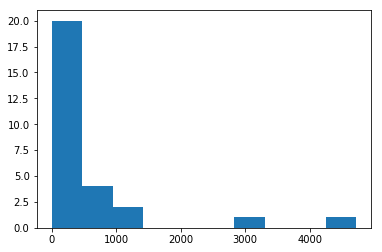

In [16]:
import matplotlib.pyplot as plt
plt.hist( (Yhat>th+0.5).sum(axis=0) )


In [84]:
pred = [ ' '.join( map(str,np.where( yhat > 0.4 )[0]) ) for yhat in  Yhat]
#code  = ' '.join( map(str, code) )
len(np.where( np.array([1,2,3]) < 0 )[0]) 

0

In [45]:
# submission_filepath = 'submission.csv'
# th=0.5
# #submission = [ {'Id': Id, 'Predicted': ' '.join( map(str, np.where( yhat > th )[0])  if len(np.where( yhat > th )[0])>0 else '0'  ) }  for (Id, yhat) in zip( iDs,Yhat) ]
# submission = [ {'Id': Id, 'Predicted': ' '.join( map(str, np.where( yhat > th )[0]) ) }  for (Id, yhat) in zip( iDs,Yhat) ]
# submission = pd.DataFrame( submission )
# submission.to_csv(submission_filepath, index=False, encoding='utf-8')
# print('SAVE!!!')
# submission


In [19]:
ths = np.array([0.2375, 0.0375, 0.0875, 0.0375, 0.0125, 0.0375, 0.025, 0.05625,
       0.0, 0.0, 0.0, 0.025, 0.025, 0.0125, 0.025, 0.0, 0.01875, 0.00625,
       0.025, 0.00625, 0.00625, 0.08125, 0.0125, 0.06875, 0.00625, 0.15,
       0.0, 0.0])

In [28]:
submission_filepath = 'submission.csv'
th=ths + 0.5
submission = pd.read_csv('~/.kaggle/competitions/human-protein-atlas-image-classification/sample_submission.csv')

#submission = [ {'Id': Id, 'Predicted': ' '.join( map(str, np.where( yhat > th )[0])  if len(np.where( yhat > th )[0])>0 else '0'  ) }  for (Id, yhat) in zip( iDs,Yhat) ]
submission_local = [ {'Id': Id, 'Predicted': ' '.join( map(str, np.where( yhat > th )[0]) ) }  for (Id, yhat) in zip( iDs,Yhat) ]
submission_local = pd.DataFrame( submission_local )
submission.loc[ submission['Id'] == submission_local['Id'], 'Predicted'] = submission_local['Predicted']
submission.to_csv(submission_filepath, index=False, encoding='utf-8')
submission


,Id,Predicted
0,00008af0-bad0-11e8-b2b8-ac1f6b6435d0,2
1,0000a892-bacf-11e8-b2b8-ac1f6b6435d0,5
2,0006faa6-bac7-11e8-b2b7-ac1f6b6435d0,0 5 25
3,0008baca-bad7-11e8-b2b9-ac1f6b6435d0,0
4,000cce7e-bad4-11e8-b2b8-ac1f6b6435d0,25
5,00109f6a-bac8-11e8-b2b7-ac1f6b6435d0,4
6,001765de-bacd-11e8-b2b8-ac1f6b6435d0,0 25
7,0018641a-bac9-11e8-b2b8-ac1f6b6435d0,25
8,00200f22-bad7-11e8-b2b9-ac1f6b6435d0,0
9,0026f154-bac6-11e8-b2b7-ac1f6b6435d0,0 25


In [27]:
!kaggle competitions submit -c human-protein-atlas-image-classification -f submission.csv -m "resnet50+mix+512x512+extern+epoch50+ep01+multth05"

100%|█████████████████████████████████████████| 464k/464k [00:00<00:00, 524kB/s]
Successfully submitted to Human Protein Atlas Image Classification

In [13]:

f1 = pd.read_csv('~/.kaggle/competitions/human-protein-atlas-image-classification/sample_submission.csv')
f1.drop('Predicted', axis=1, inplace=True)
f2 = pd.read_csv('submission.csv')
f1 = f1.merge(f2, left_on='Id', right_on='Id', how='outer')
f1.to_csv('new_submission.csv', index=False)


In [ ]:
#!kaggle competitions submit -c human-protein-atlas-image-classification -f new_submission.csv -m "resnet18+mix+512x512+extern+sort"

In [24]:
submission = pd.read_csv('/root/.kaggle/competitions/human-protein-atlas-image-classification/sample_submission.csv')
submission

,Id,Predicted
0,00008af0-bad0-11e8-b2b8-ac1f6b6435d0,0
1,0000a892-bacf-11e8-b2b8-ac1f6b6435d0,0
2,0006faa6-bac7-11e8-b2b7-ac1f6b6435d0,0
3,0008baca-bad7-11e8-b2b9-ac1f6b6435d0,0
4,000cce7e-bad4-11e8-b2b8-ac1f6b6435d0,0
5,00109f6a-bac8-11e8-b2b7-ac1f6b6435d0,0
6,001765de-bacd-11e8-b2b8-ac1f6b6435d0,0
7,0018641a-bac9-11e8-b2b8-ac1f6b6435d0,0
8,00200f22-bad7-11e8-b2b9-ac1f6b6435d0,0
9,0026f154-bac6-11e8-b2b7-ac1f6b6435d0,0
